# Modelos de ANN

1. Instalar librerias

!pip install keras
!pip install tensorflow

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models_bench import ANNModel
from sklearn.preprocessing import StandardScaler
from keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers, optimizers
from bayes_opt import BayesianOptimization
 

ModuleNotFoundError: No module named 'keras'

2. Cargar datos

In [2]:
df_ = pd.read_excel('D:\Tesis SUT\Data\Bases Tesis Originales.xlsx',
                        sheet_name="Bases Publicadas",
                        header=None, 
                        skiprows = 2, 
                        usecols="C:U", 
                        nrows=60)

3. Preparación de los datos ANNModel y LSTMModel

In [6]:
# Arreglo de datos para entrenamiento y prueba
def depura_data(i, n_fore, prop):
    """Creates a model that can predict new data.
        Args:
        i: Actividad económica.
        n_fore: Número de pasos adelante para predicción.
        prop: Proporción de datos para entrenamiento.
        """
    df = pd.DataFrame()
    df['y'] = df_[i+2]
    df["CL"] = pd.read_csv(
        r'D:\Tesis SUT\Results\Chow y Lin\hat_y.csv', header=None)[i]
    df['Fer'] = pd.read_csv(
        r'D:\Tesis SUT\Results\Fernandez\hat_y.csv', header=None)[i]
    df['Lit'] = pd.read_csv(
        r'D:\Tesis SUT\Results\Litterman\hat_y.csv', header=None)[i]
    df['Pro'] = pd.read_csv(
        r'D:\Tesis SUT\Results\Proietti\hat_y.csv', header=None)[i]
    df['SSC'] = pd.read_csv(
        r'D:\Tesis SUT\Results\Santos Silva y Cardoso\hat_y.csv', header=None)[i]
    per_fore = n_fore
    len_all = df.shape[0]-n_fore
    len = round((df.shape[0] - n_fore)*prop)
    len_fore = len - per_fore

    # Prepare data
    y_train = df.iloc[:len, :1].to_numpy()
    x_train = df.iloc[:len, 1:].to_numpy()
    y_test = df.iloc[len:len_all-1, :1].to_numpy()
    x_test = df.iloc[len:len_all-1, 1:].to_numpy()
    x_fore = df.iloc[len_all:, 1:].to_numpy()
    x_all = df.iloc[:, 1:].to_numpy()
    y_all = df.iloc[:, :1].to_numpy()
    return y_train, x_train, y_test, x_test, x_all,y_all

# Model LSMT para desagregar
def depura_data_lsmt(i, n_fore, prop):
    """Creates a model that can predict new data.

    Args:
        i: Actividad económica.
        n_fore: Número de pasos adelante para predicción.
        prop: Proporción de datos para entrenamiento.
    Returns:
        y_train: Variable dependiente de entrenamiento.
        x_train: Variables independientes de entrenamiento.
        y_test: Variable dependiente de prueba.
        x_test: Variables independientes de prueba.
        x_fore: Variables independientes para pronóstico.
        x_all: Variables independientes para pronóstico.
        y_all: Variable dependiente para pronóstico.    
        """
    df = pd.DataFrame()
    df['y'] = df_[i+2]
    df["CL"] = pd.read_csv(
        r'D:\Tesis SUT\Results\Chow y Lin\hat_y.csv', header=None)[i]
    df['Fer'] = pd.read_csv(
        r'D:\Tesis SUT\Results\Fernandez\hat_y.csv', header=None)[i]
    df['Lit'] = pd.read_csv(
        r'D:\Tesis SUT\Results\Litterman\hat_y.csv', header=None)[i]
    df['Pro'] = pd.read_csv(
        r'D:\Tesis SUT\Results\Proietti\hat_y.csv', header=None)[i]
    df['SSC'] = pd.read_csv(
        r'D:\Tesis SUT\Results\Santos Silva y Cardoso\hat_y.csv', header=None)[i]
    per_fore = n_fore
    len_all = df.shape[0]-n_fore
    len = round((df.shape[0] - n_fore)*prop)
    len_fore = len - per_fore

    # Prepare data
    y_train = df.iloc[:len, :1].to_numpy()/1000
    x_train = df.iloc[:len, 1:].to_numpy()/1000
    y_test = df.iloc[len:len_all-1, :1].to_numpy()/1000
    x_test = df.iloc[len:len_all-1, 1:].to_numpy()/1000
    x_fore = df.iloc[len_all:, 1:].to_numpy()/1000
    x_all = df.iloc[:, 1:].to_numpy()/1000
    y_all = df.iloc[:, :1].to_numpy()/1000



    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    x_fore = np.reshape(x_fore, (x_fore.shape[0], x_fore.shape[1], 1))
    x_all = np.reshape(x_all, (x_all.shape[0], x_all.shape[1], 1))
    
    return y_train, x_train, y_test, x_test, x_all,y_all    

# Modelo ANN para desagregar
def model_data(proc, i, y_train, x_train, y_test, x_test, x_all,n1,n2):
    """Creates a model that can predict new data.

    Args:
        proc: Dataframe con los resultados.
        i: Actividad económica.
        y_train: Variable dependiente de entrenamiento.
        x_train: Variables independientes de entrenamiento.
        y_test: Variable dependiente de prueba.
        x_test: Variables independientes de prueba.
        x_all: Variables independientes de todos los datos.
        n1: Número de neuronas en la primera capa.
        n2: Número de neuronas en la segunda capa.

    Returns:
        A tuple of the model and the forecast.
    """

    # Create the model
    model = Sequential()
    model.add(Dense(units=n1, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
    #model.add(Dropout(0.2))
    model.add(Dense(units=n2, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
    #model.add(Dropout(0.2))
    model.add(Dense(units=y_train.shape[1], activation='linear'))

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.0010)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # Train the model
    model.fit(x_train, y_train, epochs=100, batch_size=8, validation_data=(x_test, y_test), verbose=1)
    history = model.history
    
    # Evaluate the model
    #loss = model.evaluate(x_test, y_test)

    # Forecast
    forecast = model.predict(x_all)
    proc[i] = pd.DataFrame(forecast)

    # Return the model and the forecast
    return model, forecast, history

# Modelo lsmt para desagregar
def model_lsmt(proc, i, y_train, x_train, y_test, x_test, x_all,n1,n2):
    """Creates a model that can predict new data.

    Args:
        proc: Dataframe con los resultados.
        i: Actividad económica.
        y_train: Variable dependiente de entrenamiento.
        x_train: Variables independientes de entrenamiento.
        y_test: Variable dependiente de prueba.
        x_test: Variables independientes de prueba.
        x_all: Variables independientes de todos los datos.
        n1: Número de neuronas en la primera capa.
        n2: Número de neuronas en la segunda capa.

    Returns:
        Modelo y forecast en un dataframe.
    """
  # Create the model.
    model = Sequential()
    model.add(LSTM(n1, input_shape=(x_train.shape[1], 1), return_sequences=True))
    model.add(LSTM(n2, return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.001))
    model.add(Dense(1))

    # Compile the model.
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model.
    model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=1)

    # Evaluate the model
    train_loss = model.evaluate(x_train, y_train, verbose=0)
    print('Train Loss:', train_loss)

    # Make predictions
    predictions = model.predict(x_test)
    # Evaluate the model
    mse_test = model.evaluate(x_test, y_test, verbose=0)
    print(f'MSE on test set: {mse_test:.4f}')
   # Forecast
    
    forecast = model.predict(x_all)
    new_column = list(range(60))
    proc[19] = new_column
    proc[i] = pd.DataFrame(forecast)

    return model, forecast

# Graficas de test 
def plot_func(y_test, x_test, model, i):
    """Creates a model that can predict new data.

    Args:
        y_test: Variable dependiente de prueba.
        x_test: Variables independientes de prueba.
        model: Modelo a utilizar.
        i: Serie a desagregar.
    """
    predictions = model.predict(x_test)
    # Check if the directory already exists. If it does, delete it.
    if not os.path.exists('plots'):
        os.makedirs('plots')

    # Check if the file already exists. If it does, delete it.
    if os.path.exists('plots/predictions{}.png'.format(i)):
        os.remove('plots/predictions{}.png'.format(i))

    # Plot the predictions
    plt.plot(y_test, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.title('Actual vs Predicted')
    plt.savefig('plots/predictions{}.png'.format(i))
    plt.close()
    plt.show()
    
# Graficas de learning curves
def plt_learning(history,i):
    """Creates a model that can predict new data.

    Args:
        model: Modelo a utilizar.
        i: Serie a desagregar.
    """
    
    # Check if the directory already exists. If it does, delete it.
    if not os.path.exists('plots_learning'):
        os.makedirs('plots_learning')

    # Check if the file already exists. If it does, delete it.
    if os.path.exists('plots_learning/predictions{}.png'.format(i)):
        os.remove('plots_learning/predictions{}.png'.format(i))
    
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Save the plot
    plt.savefig('plots_learning/predictions{}.png'.format(i))
    plt.close()
    plt.show()

# Graficas de predicciones
def plot_model(y_all, forecast, i):
    """Creates a model that can predict new data.

    Args:
        y_all: Variable dependiente de todos los datos.
        forecast: Predicciones.
        i: Serie a desagregar.
    """

    # Check if the plots directory exists. If not, create it.
    if not os.path.exists('plots_model'):
        os.makedirs('plots_model')

    # Check if the file already exists. If it does, delete it.
    if os.path.exists('plots_model/predictions{}.png'.format(i)):
        os.remove('plots_model/predictions{}.png'.format(i))

    # Plot the data
    plt.figure(figsize=(15, 8))
    plt.plot(y_all, label='True')
    plt.plot(forecast, label='NN')
    plt.title("ANN's Prediction")
    plt.xlabel('Observation')
    plt.ylabel('Adj Close Scaled')
    plt.legend()

    # Save the plot
    plt.savefig('plots_model/predictions{}.png'.format(i))

    # Close the plot
    plt.close()

# Función para optimizar el modelo
def wrapped_model_data(n1, n2):
    """Creates a model that can predict new data.

    Args:
        n1: Número de neuronas en la primera capa.
        n2: Número de neuronas en la segunda capa.

    Returns:
        Modelo para optimizar.
    """
    n1 = int(n1)
    n2 = int(n2)
    model, forecast, history = model_data(proc, i, y_train, x_train, y_test, x_test, x_all, n1, n2)
    val_loss = np.min(history.history['val_loss'])
    return -val_loss

# Función para optimizar el modelo con bayes
def opt_bay(wrapped_model_data):
    """Creates a model that can predict new data.

    Args:
        wrapped_model_data: Función a optimizar.

    Returns:
        Número de neuronas óptimas.
    """
    bounds = {'n1': (5, 400), 'n2': (5, 400)}
    optimizer = BayesianOptimization(
        f=wrapped_model_data, 
        pbounds=bounds, 
        random_state=1)
    optimizer.maximize(init_points=5, n_iter=20)
    optimal_n1 = int(optimizer.max['params']['n1'])
    optimal_n2 = int(optimizer.max['params']['n2'])
    return optimal_n1,optimal_n2




### Modelo para la deteminar el número de neuronas óptimas

In [4]:
# Función para desagregar los datos
proc = pd.DataFrame(columns=range(19))
for i in range(19):
    y_train, x_train, y_test, x_test, x_all,y_all = depura_data(i,4,0.8)
    optimal_n1, optimal_n2 = opt_bay(wrapped_model_data)
 # Modelo
    model, forecast, history = model_data(proc, i, y_train, x_train, y_test, x_test, x_all, optimal_n1, optimal_n2)
    plot_func(y_test, x_test, model,i)
    plt_learning(history,i)
    plot_model(y_all,forecast,i)
proc = proc.iloc[:, :-1]
proc.to_csv(r'D:\Tesis SUT\Results\ANN\hat_y.csv', index = False, header=False)
print(proc)

|   iter    |  target   |    n1     |    n2     |
-------------------------------------------------
Epoch 1/100
6/6 [==============================] - 1s 45ms/step - loss: 86243992.0000 - val_loss: 10489322.0000
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 15389916.0000 - val_loss: 58515944.0000
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 14784617.0000 - val_loss: 11067178.0000
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 5617128.0000 - val_loss: 18805308.0000
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 8025455.5000 - val_loss: 13806435.0000
Epoch 6/100
6/6 [==============================] - 0s 13ms/step - loss: 5001630.0000 - val_loss: 10842970.0000
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 5341096.5000 - val_loss: 11610478.0000
Epoch 8/100
6/6 [==============================] - 0s 12ms/step - loss: 4732998.5000 - val_loss: 9844061.0000
Epoch 9/10

In [19]:
plot_model(y_all,forecast,i)

## Cálculo de los modelos  ANN

In [9]:
proc = pd.DataFrame(columns=range(19))
new_column = list(range(60))
proc[proc.shape[1]] = new_column
## Model 1 n1 = 64, n2 = 32
model1 = {1,9,11,15,17}

for i in model1:
    # Create DataFrame
    y_train, x_train, y_test, x_test, x_all,y_all = depura_data(i,4,0.8)
    
    # Create the model
    model, forecast,history = model_data(proc, i, y_train, x_train, y_test, x_test, x_all, 64, 32)

    # Plots 
    plot_func(y_test, x_test, model,i)
    plt_learning(history,i)
    plot_model(y_all,forecast,i)

## Model 2 n1 = 128, n2 = 64
model2 = {0,3,10,13,14,18}

for i in model2:
    # Create DataFrame
    y_train, x_train, y_test, x_test, x_all,y_all = depura_data(i,4,0.8)
    
    # Create the model
    model, forecast,history = model_data(proc, i, y_train, x_train, y_test, x_test, x_all, 128, 64)

    # Plots 
    plot_func(y_test, x_test, model,i)
    plt_learning(history,i)
    plot_model(y_all,forecast,i)

## Model 3 n1 = 100, n2 = 50
model3 = {5,6,16}

for i in model3:
    # Create DataFrame
    y_train, x_train, y_test, x_test, x_all,y_all = depura_data(i,4,0.8)
    
    # Create the model
    model, forecast,history = model_data(proc, i, y_train, x_train, y_test, x_test, x_all, 100, 50)

    # Plots 
    plot_func(y_test, x_test, model,i)
    plt_learning(history,i)
    plot_model(y_all,forecast,i)

## Model 4 n1 = 150, n2 = 300
model4 = {2,4,7,8,12}

for i in model4:
    # Create DataFrame
    y_train, x_train, y_test, x_test, x_all,y_all = depura_data(i,4,0.8)
    optimal_n1, optimal_n2 = opt_bay(wrapped_model_data)
 # Modelo
    model, forecast, history = model_data(proc, i, y_train, x_train, y_test, x_test, x_all, optimal_n1, optimal_n2)
    plot_func(y_test, x_test, model,i)
    plt_learning(history,i)
    plot_model(y_all,forecast,i)

# Save the proc dataframe
proc = proc.iloc[:, :-1]
proc.to_csv(r'D:\Tesis SUT\Results\ANN\hat_y.csv', index = False, header=False)
print(proc)

Epoch 1/100
6/6 [==============================] - 1s 38ms/step - loss: 5303334.5000 - val_loss: 95928.9766
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 985625.8750 - val_loss: 4997363.0000
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 1102400.1250 - val_loss: 160120.0781
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 313145.8750 - val_loss: 1033654.6250
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 394991.5938 - val_loss: 63525.9141
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 109952.1797 - val_loss: 360695.4375
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 144387.4844 - val_loss: 53087.9570
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 90196.3594 - val_loss: 86833.4297
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 90883.9141 - val_loss: 26413.8906
Epoch 10/100
6/6 [===============

### Model LSTM

In [39]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import regularizers
from keras.regularizers import l2

proc = pd.DataFrame(columns=range(19))

for i in range(19):
    
    # Reshape the input data
    y_train, x_train, y_test, x_test, x_all,y_all = depura_data_lsmt(i,4,0.8)
    
    # Create the LSTM model
    model, forecast = model_lsmt(proc, i, y_train, x_train, y_test, x_test, x_all,128,64)
    plot_model(y_all,forecast,i)
proc = proc.iloc[:, :-1]*1000
proc.to_csv(r'D:\Tesis SUT\Results\LSMT\hat_y.csv', index = False, header=False)
print(proc)

Epoch 1/100
45/45 [==============================] - 4s 5ms/step - loss: 58.1021
Epoch 2/100
45/45 [==============================] - 0s 5ms/step - loss: 15.1819
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 14.9173
Epoch 4/100
45/45 [==============================] - 0s 4ms/step - loss: 14.3508
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 13.4695
Epoch 6/100
45/45 [==============================] - 0s 4ms/step - loss: 7.5961
Epoch 7/100
45/45 [==============================] - 0s 4ms/step - loss: 5.9466
Epoch 8/100
45/45 [==============================] - 0s 4ms/step - loss: 5.9945
Epoch 9/100
45/45 [==============================] - 0s 4ms/step - loss: 4.8940
Epoch 10/100
45/45 [==============================] - 0s 4ms/step - loss: 4.3906
Epoch 11/100
45/45 [==============================] - 0s 4ms/step - loss: 5.6274
Epoch 12/100
45/45 [==============================] - 0s 4ms/step - loss: 4.5448
Epoch 13/100
45/45 [============

In [48]:
import matplotlib.pyplot as plt
plt.plot(df['y'], label = 'Real data')
plt.plot(df['CL'], label = 'Chow y Lin')
plt.plot(df['Fer'], label = 'Fernandez')
plt.plot(df['Lit'], label = 'Litterman')
plt.plot(df['Pro'], label = 'Proietti')
plt.plot(df['SSC'], label = 'Santos Silva y Cardoso')
plt.title('Prediction')
plt.legend()
plt.show()


KeyError: 'y'

1/1 [==============================] - 0s 22ms/step


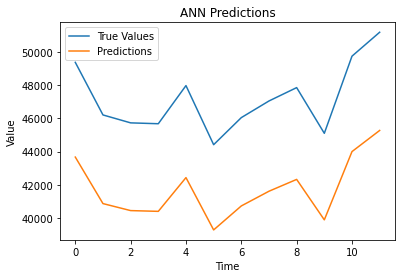

array([[43668.625],
       [40866.46 ],
       [40444.535],
       [40398.684],
       [42431.664],
       [39280.53 ],
       [40725.32 ],
       [41611.375],
       [42323.344],
       [39886.836],
       [43998.742],
       [45272.375]], dtype=float32)

In [8]:
import matplotlib.pyplot as plt

# Make predictions on the test data
test_predictions = model.predict(x_test)

# Plot the predictions
plt.plot(y_test, label='True Values')
plt.plot(test_predictions, label='Predictions')
plt.title('ANN Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


test_predictions
#model.predict(x_fore)   


In [5]:

#   LSMT model
proc = pd.DataFrame(columns=range(18))
for i in range(18):

    df = pd.DataFrame()
    df['y'] = df_[i+2]
    df["CL"]  = pd.read_csv(r'D:\Tesis SUT\Results\Chow y Lin\hat_y.csv',header=None)[i]
    df['Fer'] = pd.read_csv(r'D:\Tesis SUT\Results\Fernandez\hat_y.csv',header=None)[i]
    df['Lit'] = pd.read_csv(r'D:\Tesis SUT\Results\Litterman\hat_y.csv',header=None)[i]
    df['Pro'] = pd.read_csv(r'D:\Tesis SUT\Results\Proietti\hat_y.csv',header=None)[i]
    df['SSC'] = pd.read_csv(r'D:\Tesis SUT\Results\Santos Silva y Cardoso\hat_y.csv',header=None)[i]

    #Preparar el conjunto de datos
    y_train = df.iloc[:43, :1]
    x_train = df.iloc[:43, 1:]
    y_test = df.iloc[43:55 , :1]
    x_test = df.iloc[43:55 , 1:]

    x_fore = df.iloc[55:,1:]

    y_train = y_train.to_numpy()
    x_train = x_train.to_numpy()
    y_test  = y_test.to_numpy()
    x_test  = x_test.to_numpy()
    x_all = df.iloc[:,1:].to_numpy()

    # Creando el modelo 
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=y_train.shape[1], activation='linear'))
    #model = Sequential()
    #model.add(LSTM(units=64, input_shape=(timesteps, input_dim)))
    #model.add(Dense(units=output_dim, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



    # Compilar y  ajustar el modelo
    #model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=50, batch_size=32)


    # Evaluate the model on the test data
    test_loss = model.evaluate(x_test, y_test)

    # Use the trained model to make predictions on new data
    train = model.predict(x_train)
    predictions = model.predict(x_test)
    # Forecast 
    forecast = model.predict(x_fore)


    results = pd.DataFrame(train)
    results = results.append(pd.DataFrame(predictions), ignore_index=True)
    results = results.append(pd.DataFrame(forecast), ignore_index=True)

    #results.append(train, ignore_index=True)
    #results.append(pd.DataFrame(predictions), ignore_index=True)
    #results.append(pd.DataFrame(forecast), ignore_index=True)

  
    #proc.index = range(len(results))
    new_column = list(range(60))
    proc[17] = new_column
    proc[i] = results


Epoch 1/50
2/2 [==============================] - 1s 8ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Epoch 7/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Epoch 8/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Epoch 9/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Epoch 10/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.0000e+00

In [5]:
proc.to_csv('D:\Tesis SUT\Results\ANN\example.csv', index=False)

Epoch 1/50
2/2 [==============================] - 0s 3ms/step - loss: 18742322.0000
Epoch 2/50
2/2 [==============================] - 0s 4ms/step - loss: 18744204.0000
Epoch 3/50
2/2 [==============================] - 0s 3ms/step - loss: 18705174.0000
Epoch 4/50
2/2 [==============================] - 0s 3ms/step - loss: 18696062.0000
Epoch 5/50
2/2 [==============================] - 0s 4ms/step - loss: 18690406.0000
Epoch 6/50
2/2 [==============================] - 0s 5ms/step - loss: 18678422.0000
Epoch 7/50
2/2 [==============================] - 0s 2ms/step - loss: 18647318.0000
Epoch 8/50
2/2 [==============================] - 0s 8ms/step - loss: 18634616.0000
Epoch 9/50
2/2 [==============================] - 0s 4ms/step - loss: 18643916.0000
Epoch 10/50
2/2 [==============================] - 0s 5ms/step - loss: 18667432.0000
Epoch 11/50
2/2 [==============================] - 0s 3ms/step - loss: 18924294.0000
Epoch 12/50
2/2 [==============================] - 0s 9ms/step - loss: 190

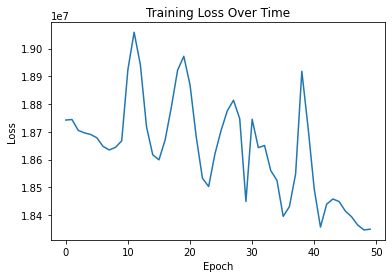

In [5]:
# Train the model on the training data
history = model.fit(x_train, y_train, epochs=50, batch_size=32)

# Plot the training loss over time
plt.plot(history.history['loss'])
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Epoch 1/60
3/3 [==============================] - 0s 37ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 2/60
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 3/60
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 4/60
3/3 [==============================] - 0s 19ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 5/60
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 6/60
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 7/60
3/3 [==============================] - 0s 15ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.005

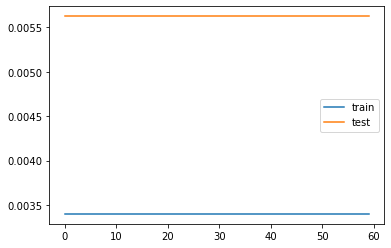

In [6]:
# Train the model
history = model.fit(x_train, y_train, epochs=60, batch_size=20, validation_data=(x_test, y_test))

# Plot the train and test loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [7]:
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

1/1 [==============================] - 0s 22ms/step


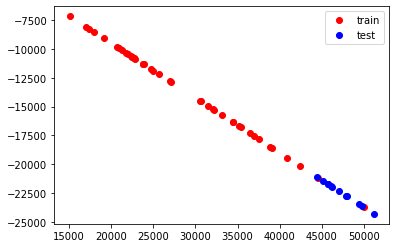

In [8]:
# Plot the train and test predictions
plt.plot(y_train, train_predictions, 'ro', label='train')
plt.plot(y_test, test_predictions, 'bo', label='test')
plt.legend()
plt.show()

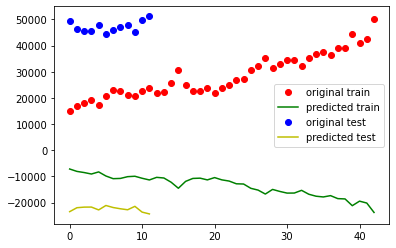

In [9]:
# Plot the train and test predictions
plt.plot(y_train, 'ro', label='original train')
plt.plot(train_predictions, 'g', label='predicted train')
plt.plot(y_test, 'bo', label='original test')
plt.plot(test_predictions, 'y', label='predicted test')
plt.legend()
plt.show()

1/1 [==============================] - 0s 20ms/step


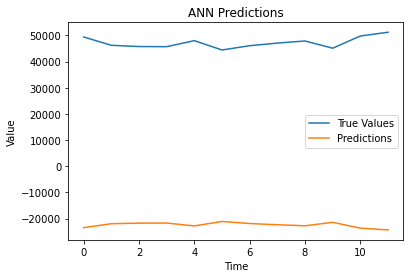

In [10]:
import matplotlib.pyplot as plt

# Make predictions on the test data
test_predictions = model.predict(x_test)

# Plot the predictions
plt.plot(y_test, label='True Values')
plt.plot(test_predictions, label='Predictions')
plt.title('ANN Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [11]:
predictions = model.predict(x_train)
df = pd.DataFrame(predictions, columns=['Predict Model'])

# write the dataframe to an Excel file
df.to_excel('D:\Tesis SUT\Data\Predict.xlsx', index=False)

2/2 [==============================] - 0s 3ms/step


In [11]:
import numpy as np
import tensorflow as tf

proc = pd.DataFrame(columns=range(17))
#for i in range(0):
for i in range(17):
    df = pd.DataFrame()
    df['y'] = df_[i+2]
    df["CL"]  = pd.read_csv(r'D:\Tesis SUT\Results\Chow y Lin\hat_y.csv',header=None)[i]
    df['Fer'] = pd.read_csv(r'D:\Tesis SUT\Results\Fernandez\hat_y.csv',header=None)[i]
    df['Lit'] = pd.read_csv(r'D:\Tesis SUT\Results\Litterman\hat_y.csv',header=None)[i]
    df['Pro'] = pd.read_csv(r'D:\Tesis SUT\Results\Proietti\hat_y.csv',header=None)[i]
    df['SSC'] = pd.read_csv(r'D:\Tesis SUT\Results\Santos Silva y Cardoso\hat_y.csv',header=None)[i]

    #Preparar el conjunto de datos
    y_train = df.iloc[:43, :1]
    x_train = df.iloc[:43, 1:]
    y_test = df.iloc[43:55 , :1]
    x_test = df.iloc[43:55 , 1:]

    x_fore = df.iloc[55:,1:]
    
    y_all  = df.iloc[0:55 , :1]

    y_train = y_train.to_numpy()
    x_train = x_train.to_numpy()
    y_test  = y_test.to_numpy()
    x_test  = x_test.to_numpy()
    x_all = df.iloc[:,1:].to_numpy()

    def create_model(input_shape):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.LSTM(units=76, input_shape=input_shape))
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model


    # Reshape the input data to be 3D for the LSTM model
    n_samples = x_train.shape[0]
    timesteps = 1
    n_features = 5



    xp = x_fore.to_numpy()


    train_x = x_train.reshape((n_samples, timesteps, n_features))
    test_x =  x_test.reshape((x_test.shape[0],timesteps, n_features))

    fore_x =  xp.reshape((x_fore.shape[0],timesteps, n_features))

    train_y = y_train
    test_y =  y_test


    # Normalize the data
    mean = np.mean(train_x, axis=0)
    std = np.std(train_x, axis=0)
    train_x = (train_x - mean) / std
    train_y = (train_y - np.mean(train_y)) / np.std(train_y)

    mean = np.mean(test_x, axis=0)
    std = np.std(test_x, axis=0)
    test_x = (test_x - mean) / std
    test_y = (test_y - np.mean(test_y)) / np.std(test_y)

    # Create the LSTM model
    input_shape = (1, 5)
    model = create_model(input_shape)

    # Train the model
    history = model.fit(train_x, train_y, epochs=100, batch_size=32, validation_data=(test_x, test_y), verbose=0)

    # Evaluate the model
    score = model.evaluate(test_x, test_y)
    print('Test MSE:', score)
    # Make predictions on the test data
    y_train_ = model.predict(train_x)
    y_pred_ = model.predict(test_x)
    y_fore_ = model.predict(fore_x)
    # Desnormalize the predicted y values
    y_train_desnorm = (y_train_ * np.std(y_train)) + np.mean(y_train)
    y_pred_desnorm = (y_pred_ * np.std(y_test)) + np.mean(y_test)
    y_fore_desnorm = (y_fore_ * np.std(y_test)) + np.mean(y_test)

    # Use the trained model to make predictions on new data

    results = pd.DataFrame(y_train_desnorm)
    results = results.append(pd.DataFrame(y_pred_desnorm), ignore_index=True)
    results = results.append(pd.DataFrame(y_fore_desnorm), ignore_index=True)

    #results.append(train, ignore_index=True)
        #results.append(pd.DataFrame(predictions), ignore_index=True)
        #results.append(pd.DataFrame(forecast), ignore_index=True)
    #proc.index = range(len(results))
    
    new_column = list(range(60))
    proc[17] = new_column
    proc[i] = results
  
    
    

1/1 [==============================] - 0s 22ms/step - loss: 1.0745
Test MSE: 1.0744796991348267
1/1 [==============================] - 0s 22ms/step - loss: 0.0677
Test MSE: 0.06767138093709946
1/1 [==============================] - 0s 22ms/step - loss: 0.0734
Test MSE: 0.07337657362222672
1/1 [==============================] - 0s 21ms/step - loss: 0.0270
Test MSE: 0.027035707607865334
1/1 [==============================] - 0s 22ms/step - loss: 0.5024
Test MSE: 0.5024191737174988
1/1 [==============================] - 0s 21ms/step - loss: 0.0752
Test MSE: 0.07523128390312195
1/1 [==============================] - 0s 27ms/step - loss: 0.0211
Test MSE: 0.021098515018820763
1/1 [==============================] - 0s 20ms/step - loss: 0.2804
Test MSE: 0.2804196774959564
1/1 [==============================] - 0s 21ms/step - loss: 0.0029
Test MSE: 0.0028752118814736605
1/1 [==============================] - 0s 21ms/step - loss: 0.0024
Test MSE: 0.0024357314687222242
1/1 [======================

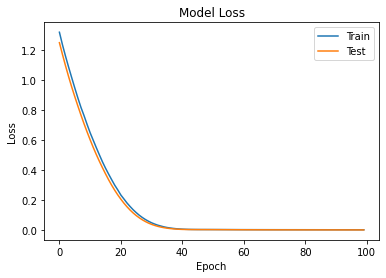

In [25]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


1/1 [==============================] - 0s 23ms/step


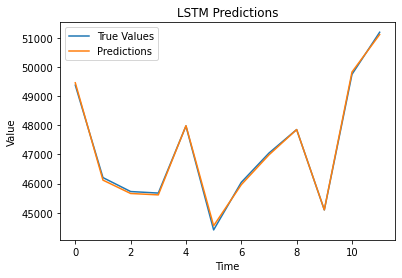

In [26]:
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = model.predict(test_x)


# Desnormalize the predicted y values
y_pred_desnorm = (y_pred * np.std(y_test)) + np.mean(y_test)
# Plot the predictions
plt.plot(y_test, label='True Values')
plt.plot(y_pred_desnorm, label='Predictions')
plt.title('LSTM Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# Tensor regress

In [16]:
import numpy as np
import tensorflow as tf

X = np.random.rand(5, 3, 3)
y = np.random.rand(5, 1, 3)

X = tf.convert_to_tensor(X, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)


In [17]:
y

<tf.Tensor: shape=(5, 1, 3), dtype=float32, numpy=
array([[[0.9915069 , 0.26829612, 0.9031111 ]],

       [[0.4707655 , 0.8771236 , 0.19301473]],

       [[0.0233345 , 0.21876074, 0.7894587 ]],

       [[0.9633789 , 0.906268  , 0.27199328]],

       [[0.07926615, 0.21397689, 0.6767948 ]]], dtype=float32)>

In [18]:


model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((9,), input_shape=(3, 3,)))
model.add(tf.keras.layers.Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')


In [19]:
history = model.fit(X, y, epochs=100, batch_size=3, verbose=0)

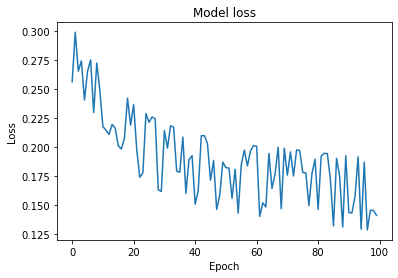

In [20]:
import matplotlib.pyplot as plt

# Plot the loss values over the epochs
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Modelos ANN multivariados

In [21]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# Prepare training data
X_train = np.array([[1, 2, 3], [4, 5, 6]])
y_train = np.array([[0.1, 0.2], [0.3, 0.4]])

# Initialize the model
model = Sequential()

# Add the first dense layer with 128 neurons and 'relu' activation
model.add(Dense(128, input_dim=3, activation='relu'))

# Add the second dense layer with 64 neurons and 'relu' activation
model.add(Dense(64, activation='relu'))

# Add the output layer with 2 neurons and 'linear' activation
model.add(Dense(2, activation='linear'))

# Compile the model using mean squared error as the loss function and 'adam' as the optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model on the training data
model.fit(X_train, y_train, epochs=100, batch_size=1)

# Use the trained model to make predictions on new data
X_test = np.array([[7, 8, 9]])
predictions = model.predict(X_test)


Epoch 1/100
2/2 [==============================] - 1s 11ms/step - loss: 0.0067
Epoch 2/100
2/2 [==============================] - 0s 9ms/step - loss: 0.0066
Epoch 3/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0112
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 5/100
2/2 [==============================] - 0s 510us/step - loss: 0.0080
Epoch 6/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0076
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 3.1637e-04
Epoch 8/100
2/2 [==============================] - 0s 9ms/step - loss: 0.0031
Epoch 9/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 10/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 11/100
2/2 [==============================] - 0s 0s/step - loss: 0.0022 
Epoch 12/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0035
Epoch 13/100
2/2 [==============================] -

In [22]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
# Define a custom constraint that restricts the sum of the output variables
class SumConstraint(Constraint):
    def __init__(self, axis=0):
        self.axis = axis

    def __call__(self, w):
        return K.sum(w, axis=self.axis)

# Generate a random dataset with three input features and two target variables
n_features = 3
n_targets = 10
n_samples = 1000
X = np.random.randn(n_samples, n_features)
y = np.random.randn(n_samples, n_targets)

# Build the neural network
model = Sequential()
model.add(Dense(10, input_dim=n_features, activation="relu"))
model.add(Dense(5, activation="relu"))
#model.add(Dense(2, activation='relu', kernel_constraint=SumConstraint(axis=1)))
model.add(Dense(n_targets, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

# Train the neural network
model.fit(X, y, epochs=50, batch_size=32, verbose=2)

# Make predictions on some new data
X_new = np.random.randn(1, n_features)
y_pred = model.predict(X_new)

# Print the predicted values
print("Predicted values:")
print(y_pred)


NameError: name 'Constraint' is not defined

In [ ]:
import keras.backend as K

# Define a custom kernel constraint function that enforces the sum of each column of y to be equal to z
def row_sum_constraint(z):
    def constraint(w):
        row_sum = K.sum(w, axis=1, keepdims=True)
        return w + (z - row_sum) / K.cast(K.shape(w)[1], K.floatx())
    return constraint

# Prepare training data
X_train = np.array([[1, 2, 3], [4, 5, 6]])
y_train = np.array([[0.1, 0.2], [0.3, 0.4]])
z = np.array([0.8, 0.9])

# Initialize the model
model = Sequential()

# Add the first dense layer with 128 neurons and 'relu' activation, and use the custom kernel constraint
model.add(Dense(128, input_dim=3, activation='relu'))

# Add the second dense layer with 64 neurons and 'relu' activation, and use the custom kernel constraint
model.add(Dense(64, activation='relu'))

# Add the output layer with 2 neurons and 'linear' activation, and use the custom kernel constraint
model.add(Dense(2, activation='linear', kernel_constraint=row_sum_constraint(z)))

# Compile the model using mean squared error as the loss function and 'adam' as the optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model on the training data
model.fit(X_train, y_train, epochs=100, batch_size=1)

# Use the trained model to make predictions on new data
X_test = np.array([[7, 8, 9]])
predictions = model.predict(X_test)





In [ ]:
# Predict on the training data
y_pred = model.predict(X_train)

# Check that the sum of each row of the predicted values is equal to z
row_sums = np.sum(y_pred, axis=1)
print(row_sums)
print(z)

In [ ]:
import keras.backend as K
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

# Define a custom kernel constraint function that enforces the sum of each row of the output to be equal to z
def row_sum_constraint(z):
    def constraint(w):
        row_sum = K.sum(w, axis=1, keepdims=True)
        return w + (z - row_sum) / K.cast(K.shape(w)[1], K.floatx())
    return constraint

# Prepare training data
X_train = np.array([[1, 2, 3], [4, 5, 6]])
y_train = np.array([[0.1, 0.2], [0.3, 0.4]])
z = np.array([5.5, 6.4])

# Initialize the model
model = Sequential()

# Add the first dense layer with 128 neurons and 'relu' activation
model.add(Dense(128, input_dim=3, activation='relu'))

# Add the second dense layer with 64 neurons and 'relu' activation
model.add(Dense(64, activation='relu'))

# Add the output layer with 2 neurons and 'linear' activation, and use the custom kernel constraint
model.add(Dense(2, activation='linear', kernel_constraint=row_sum_constraint(z)))

# Compile the model using mean squared error as the loss function and 'adam' as the optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model on the training data
model.fit(X_train, y_train, epochs=100, batch_size=1)

# Use the trained model to make predictions on X_train
predictions = model.predict(X_train)

# Compute the row sums of the predictions
row_sums = np.sum(predictions, axis=1)

# Print the row sums and z arrays
print("row_sums =", row_sums)
print("z =", z)

# Check that the row sums are equal to z
if np.allclose(row_sums, z):
    print("Row sum constraint is satisfied!")
else:
    print("Row sum constraint is not satisfied.")




In [23]:
import keras.backend as K
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

# Define a custom kernel constraint function that enforces the sum of each row of the output to be equal to z
def row_sum_constraint(z):
    def constraint(w):
        row_sum = K.sum(w, axis=1, keepdims=True)
        return w + (z - row_sum) / K.cast(K.shape(w)[1], K.floatx())
    return constraint

# Prepare training data
X_train = np.array([[1, 2, 3], [4, 5, 6]])
y_train = np.array([[0.1, 0.2], [0.3, 0.4]])
z = np.array([5.5, 6.4])

# Initialize the model
model = Sequential()

# Add the first dense layer with 128 neurons and 'relu' activation
model.add(Dense(128, input_dim=3, activation='relu'))

# Add the second dense layer with 64 neurons and 'relu' activation
model.add(Dense(64, activation='relu'))

# Add the output layer with 2 neurons and 'linear' activation, and use the custom kernel constraint
model.add(Dense(2, activation='linear', kernel_constraint=row_sum_constraint(z)))

# Compile the model using mean squared error as the loss function and 'adam' as the optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model on the training data
model.fit(X_train, y_train, epochs=100, batch_size=1)

# Use the trained model to make predictions on X_train
predictions = model.predict(X_train)

# Compute the row sums of the predictions
row_sums = np.sum(predictions, axis=1)

# Print the row sums and z arrays
print("row_sums =", row_sums)
print("z =", z)

# Check that the row sums are equal to z
if np.allclose(row_sums, z):
    print("Row sum constraint is satisfied!")
else:
    print("Row sum constraint is not satisfied.")

Epoch 1/100
2/2 [==============================] - 1s 4ms/step - loss: 1749.7867
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 1576.9109
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: 1165.1062
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 934.4440
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 635.7496
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 443.2496
Epoch 7/100
2/2 [==============================] - 0s 17ms/step - loss: 334.6695
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 219.2322
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 173.3071
Epoch 10/100
2/2 [==============================] - 0s 5ms/step - loss: 104.3225
Epoch 11/100
2/2 [==============================] - 0s 4ms/step - loss: 84.3660
Epoch 12/100
2/2 [==============================] - 0s 5ms/step - loss: 60.4631
Epoch 13/100
2/2 [=================

In [ ]:
import keras.backend as K

# Define a custom kernel constraint function that enforces the sum of each row of the output to be equal to the sum of the corresponding row in y

def constraint(w):
    row_sum = K.sum(w, axis=1, keepdims=True)
    return  row_sum


In [ ]:
# Prepare training data
X_train = np.array([[1, 2, 3], [4, 5, 6]])
y_train = np.array([[0.1, 0.2], [0.3, 0.4]])

# Calculate the row sums of y_train
y_row_sums = np.sum(y_train, axis=1)

# Define the row sum constraint using y_row_sums
row_sum_constraint_fn = constraint(y_row_sums)

# Initialize the model
model = Sequential()

# Add the first dense layer with 128 neurons and 'relu' activation
model.add(Dense(128, input_dim=3, activation='relu'))

# Add the second dense layer with 64 neurons and 'relu' activation
model.add(Dense(64, activation='relu'))

# Add the output layer with 2 neurons and 'linear' activation, and use the custom kernel constraint
model.add(Dense(2, activation='linear', kernel_constraint=row_sum_constraint_fn))

# Compile the model using mean squared error as the loss function and 'adam' as the optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model on the training data
model.fit(X_train, y_train, epochs=100, batch_size=1)

# Use the trained model to make predictions on X_train
predictions = model.predict(X_train)

# Compute the row sums of the predictions
row_sums = np.sum(predictions, axis=1)

# Check that the row sums are equal to the corresponding row sums in y_train
print(np.allclose(row_sums, y_row_sums))
print(row_sums, y_row_sums)

